In [27]:
import cv2
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

from skimage import segmentation, graph
from skimage.color import label2rgb

import matplotlib.pyplot as plt
import os
import json
import shutil
import glob
import multiprocessing
import logging

from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

C:\Users\David\anaconda3\envs\newenv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Starting to match images to data...
Processed filename: 022218JK0_C_S2_20
Number of matched rows: 1
Processed filename: 022218JK0_C_S2_20
Number of matched rows: 1
Processed filename: 022218JK0_I_S1_20
Number of matched rows: 1
Processed filename: 022218JK0_I_S1_20
Number of matched rows: 1
Processed filename: 031218JK10_I_S3_20
Number of matched rows: 1
Processed filename: 031218JK10_I_S3_20
Number of matched rows: 1
Processed filename: 040318JK12_I_S2_20
Number of matched rows: 1
Processed filename: 040318JK12_I_S2_20
Number of matched rows: 1
Processed filename: 040318JK50_I_S2_20
Number of matched rows: 1
Processed filename: 040318JK50_I_S2_20
Number of matched rows: 1
Processed filename: 040318JK7_I_S1_20
Number of matched rows: 1
Processed filename: 040318JK7_I_S1_20
Number of matched rows: 1
Shape of matched_df: (12, 4)
                        Image name          ID  Whole CA1  Average Whole CA1
0    022218JK0_C_S2_20xZpro_c1.png   022218JK0          7              4.000
1    02

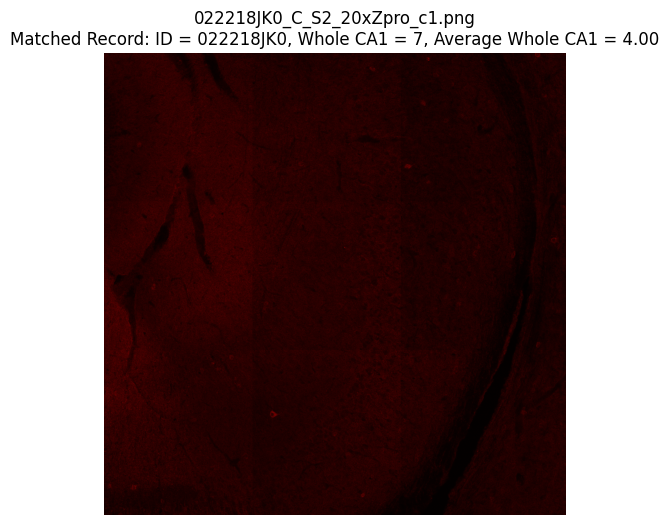

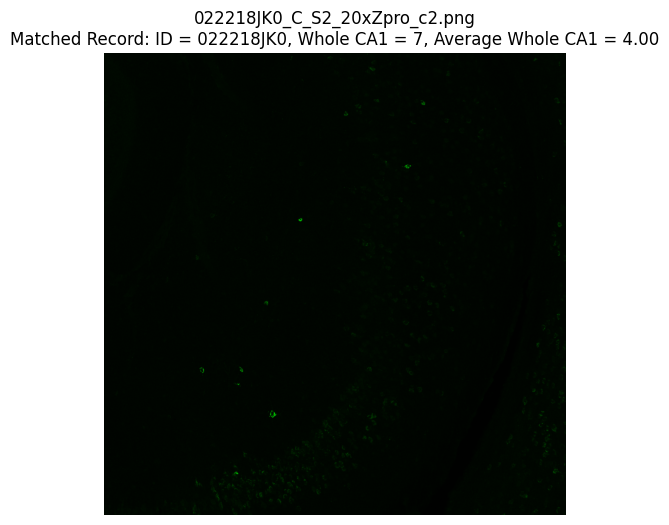

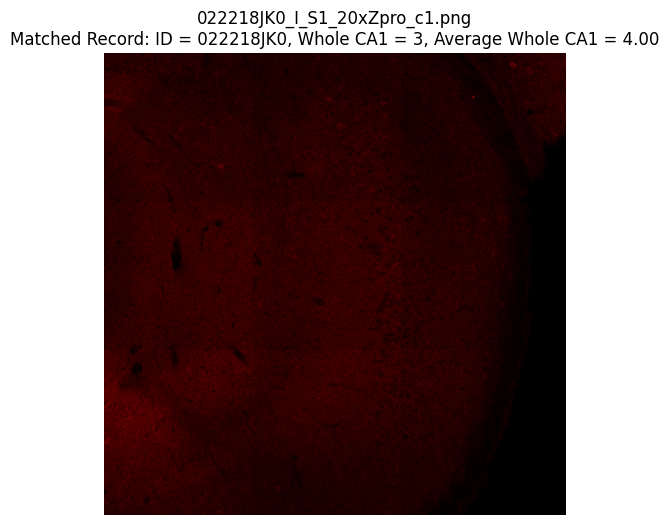

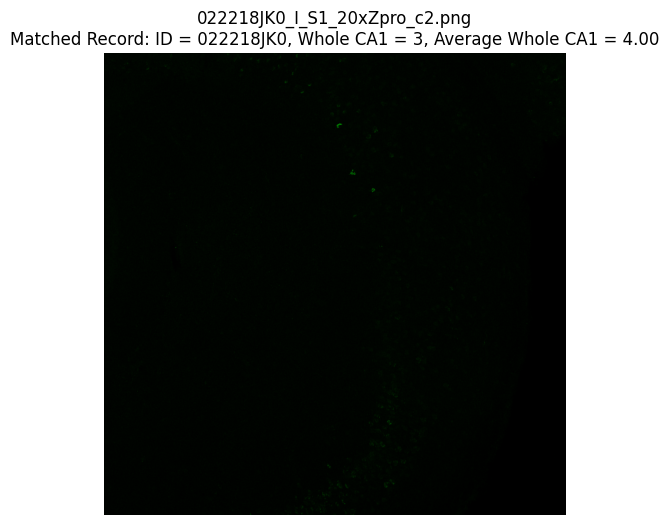

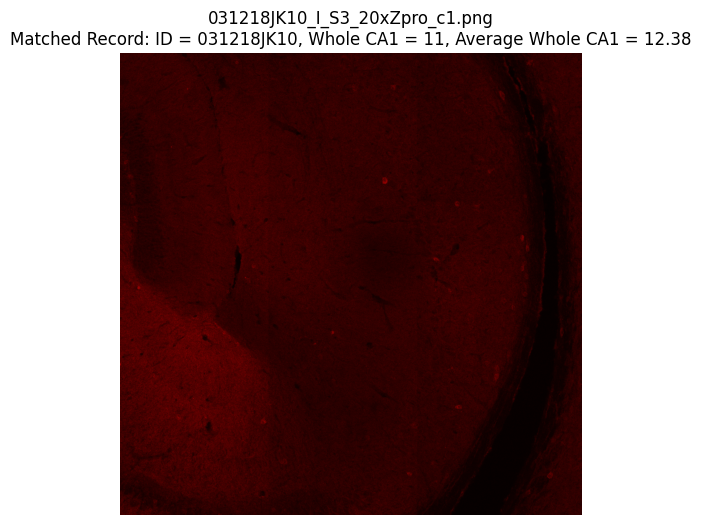

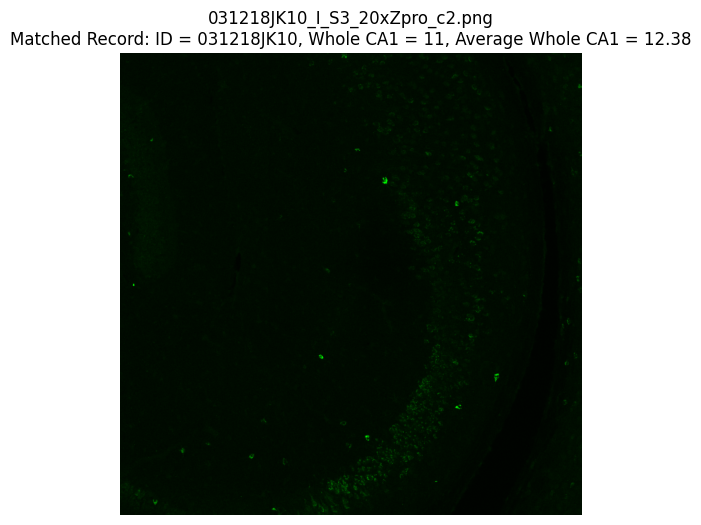

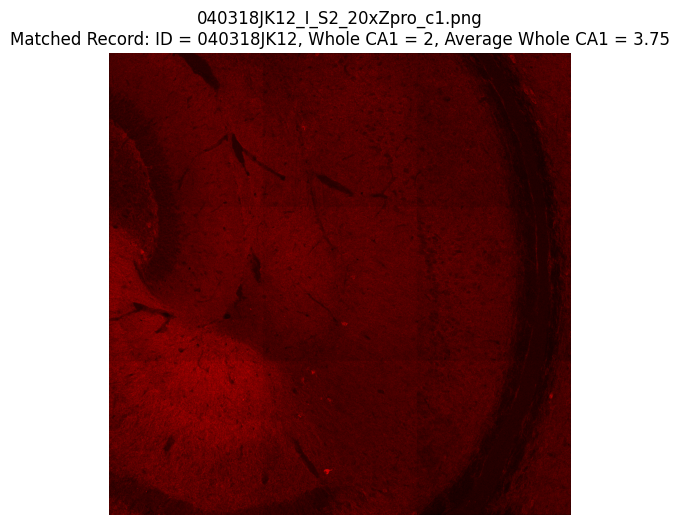

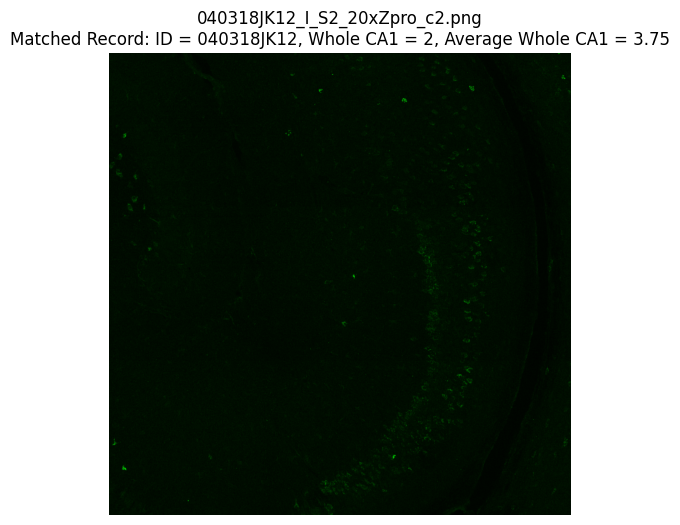

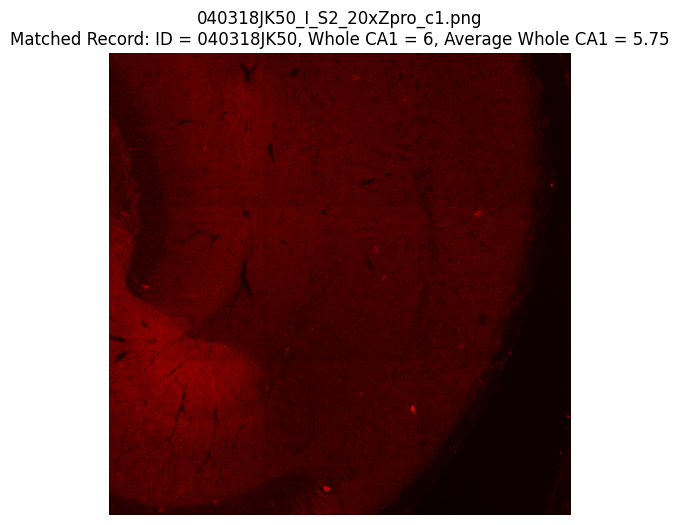

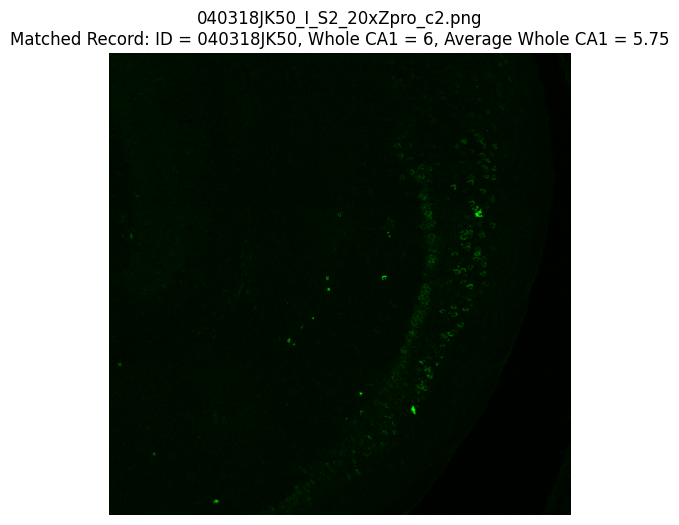

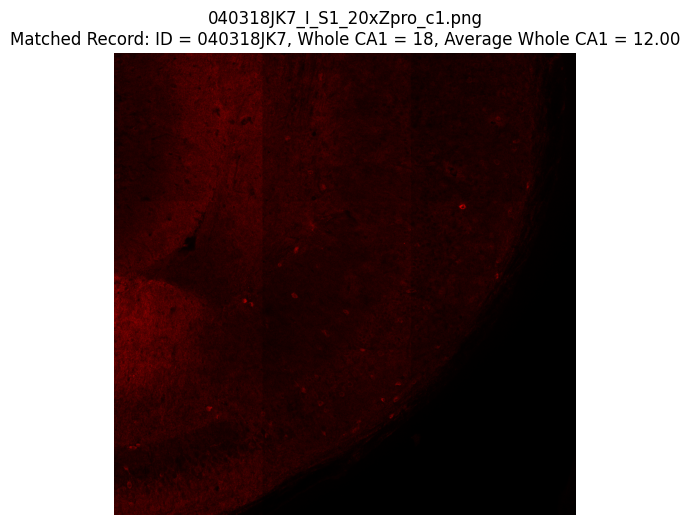

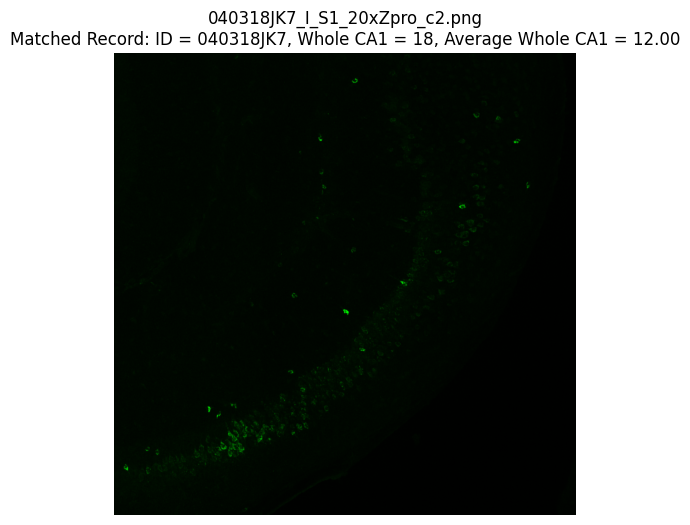

Files processed: 12, Matches found: 12
           Image name          ID Treatment  Whole CA1
0   030618JK1_C_S1_20   030618JK1    SALINE         10
1   030618JK1_C_S2_20   030618JK1    SALINE         14
2   030618JK1_I_S1_20   030618JK1    SALINE          9
3   030618JK1_I_S2_20   030618JK1    SALINE          6
4  031218JK10_C_S1_20  031218JK10    SALINE         15


In [28]:
def load_excel_data(filepath):
    df = pd.read_excel(filepath, header=1)
    df = df.iloc[:, [0, 1, 3, 14]].copy()
    df.columns = ['Image name', 'ID', 'Treatment', 'Whole CA1']
    df['Treatment'] = df['Treatment'].str.upper()
    df['Image name'] = df['Image name'].apply(lambda x: x.split('20')[0] + '20')
    df['Whole CA1'] = pd.to_numeric(df['Whole CA1'], errors='coerce').fillna(0)
    return df

def match_images_to_data(image_dir, df):
    # Compute the average 'Whole CA1' for each ID before matching
    average_ca1 = df.groupby('ID')['Whole CA1'].mean().reset_index()
    average_ca1.columns = ['ID', 'Average Whole CA1']
    df = df.merge(average_ca1, on='ID', how='left')
    
    print("Starting to match images to data...")
    files_found = matches_found = 0
    image_records = []

    for filename in os.listdir(image_dir):
        if filename.endswith('.png'):
            files_found += 1
            processed_filename = filename.split('20')[0] + '20'
            matched_rows = df[df['Image name'] == processed_filename]
            print("Processed filename:", processed_filename)  # Debug statement
            print("Number of matched rows:", len(matched_rows))  # Debug statement
    
            if not matched_rows.empty:
                matches_found += 1
                for _, row in matched_rows.iterrows():
                    image_records.append({
                        'Image name': filename,  # Corrected column name
                        'ID': row['ID'],
                        'Whole CA1': row['Whole CA1'],
                        'Average Whole CA1': row['Average Whole CA1']
                    })
            else:
                print(f"No match found for {filename}")
    
    matched_df = pd.DataFrame(image_records)
    print("Shape of matched_df:", matched_df.shape)

    if matched_df.empty:
        print("No images matched.")
    else:
        print(matched_df)

        # Display images with their matched record and average
        for _, record in matched_df.iterrows():
            image_path = os.path.join(image_dir, record['Image name'])
            display_matched_image(image_path, record)

    print(f"Files processed: {files_found}, Matches found: {matches_found}")
    return matched_df 

def display_matched_image(image_path, record):
    image = Image.open(image_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(f"{record['Image name']}\nMatched Record: ID = {record['ID']}, Whole CA1 = {record['Whole CA1']}, Average Whole CA1 = {record['Average Whole CA1']:.2f}")
    plt.axis('off')
    plt.show()

# Paths
excel_path = 'C:\\Users\\David\\Documents\\Capstone\\Final Project_Eplipesy\\Capstone_histology_data.xlsx'
images_path = 'C:\\Users\\David\\Documents\\Capstone\\Final Project_Eplipesy\\MouseNeuroImages\\original_images'

data_df = load_excel_data(excel_path)
matched_df = match_images_to_data(images_path, data_df) 
print(data_df.head())

In [29]:
def find_image_pairs(image_dir):
    """Identify pairs of images with 'c1' and 'c2' in their filenames sharing the same prefix."""
    files = os.listdir(image_dir)
    pairs = {}
    temp_dict = {}

    for file in files:
        if file.endswith('.png'):
            base_name = file.rsplit('_', 1)[0]  # Get the common prefix without the last segment
            suffix = file.split('_')[-1]  # Get the last segment, i.e., 'c1.png' or 'c2.png'

            # Ensure only 'c1' or 'c2' are considered
            if suffix in ['c1.png', 'c2.png']:
                # Map the base name to its respective 'c1' or 'c2' file
                if base_name not in temp_dict:
                    temp_dict[base_name] = {}
                temp_dict[base_name][suffix] = file

    # Build pairs from the temporary dictionary
    for base_name, suffixes in temp_dict.items():
        if 'c1.png' in suffixes and 'c2.png' in suffixes:
            pairs[suffixes['c1.png']] = suffixes['c2.png']
            print("Pair found:", suffixes['c1.png'], "with", suffixes['c2.png'])  # Debug statement

    return pairs

image_pairs = find_image_pairs(images_path)
print("Image pairs:", image_pairs)

Pair found: 022218JK0_C_S2_20xZpro_c1.png with 022218JK0_C_S2_20xZpro_c2.png
Pair found: 022218JK0_I_S1_20xZpro_c1.png with 022218JK0_I_S1_20xZpro_c2.png
Pair found: 031218JK10_I_S3_20xZpro_c1.png with 031218JK10_I_S3_20xZpro_c2.png
Pair found: 040318JK12_I_S2_20xZpro_c1.png with 040318JK12_I_S2_20xZpro_c2.png
Pair found: 040318JK50_I_S2_20xZpro_c1.png with 040318JK50_I_S2_20xZpro_c2.png
Pair found: 040318JK7_I_S1_20xZpro_c1.png with 040318JK7_I_S1_20xZpro_c2.png
Image pairs: {'022218JK0_C_S2_20xZpro_c1.png': '022218JK0_C_S2_20xZpro_c2.png', '022218JK0_I_S1_20xZpro_c1.png': '022218JK0_I_S1_20xZpro_c2.png', '031218JK10_I_S3_20xZpro_c1.png': '031218JK10_I_S3_20xZpro_c2.png', '040318JK12_I_S2_20xZpro_c1.png': '040318JK12_I_S2_20xZpro_c2.png', '040318JK50_I_S2_20xZpro_c1.png': '040318JK50_I_S2_20xZpro_c2.png', '040318JK7_I_S1_20xZpro_c1.png': '040318JK7_I_S1_20xZpro_c2.png'}


Overlaying image pairs...
Shape of matched_df: (12, 4)
Columns in matched_df: Index(['Image name', 'ID', 'Whole CA1', 'Average Whole CA1'], dtype='object')
Image names in dataset: ['022218JK0_C_S2_20xZpro_c1.png', '022218JK0_C_S2_20xZpro_c2.png', '022218JK0_I_S1_20xZpro_c1.png', '022218JK0_I_S1_20xZpro_c2.png', '031218JK10_I_S3_20xZpro_c1.png', '031218JK10_I_S3_20xZpro_c2.png', '040318JK12_I_S2_20xZpro_c1.png', '040318JK12_I_S2_20xZpro_c2.png', '040318JK50_I_S2_20xZpro_c1.png', '040318JK50_I_S2_20xZpro_c2.png', '040318JK7_I_S1_20xZpro_c1.png', '040318JK7_I_S1_20xZpro_c2.png']
Current pair 1: 022218JK0_C_S2_20xZpro_c1.png with 022218JK0_C_S2_20xZpro_c2.png


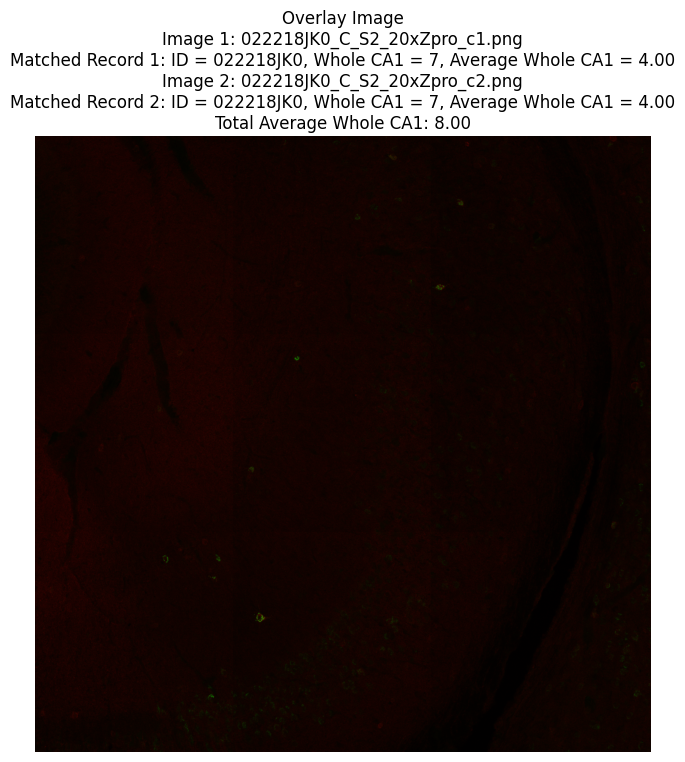

Processed pair 1/6
Current pair 2: 022218JK0_I_S1_20xZpro_c1.png with 022218JK0_I_S1_20xZpro_c2.png


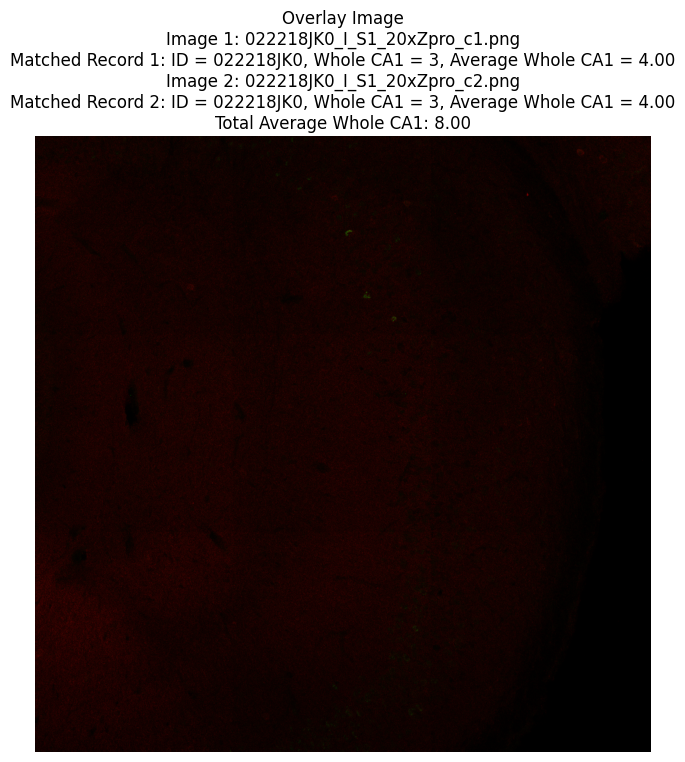

Processed pair 2/6
Current pair 3: 031218JK10_I_S3_20xZpro_c1.png with 031218JK10_I_S3_20xZpro_c2.png


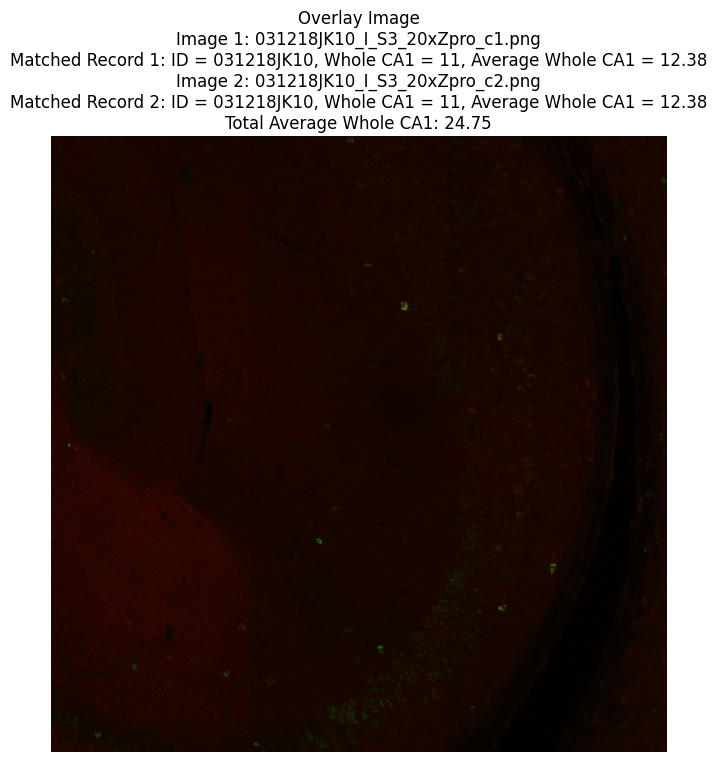

Processed pair 3/6
Current pair 4: 040318JK12_I_S2_20xZpro_c1.png with 040318JK12_I_S2_20xZpro_c2.png


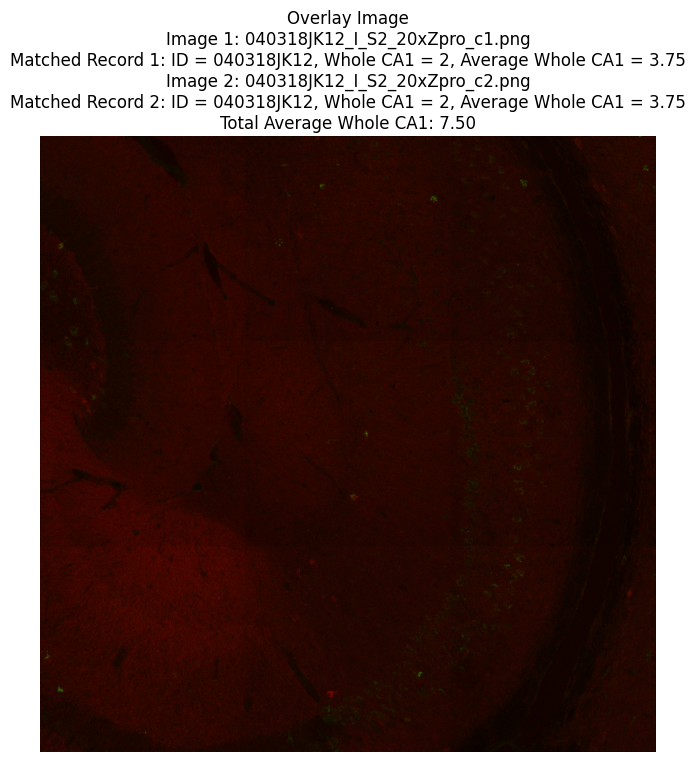

Processed pair 4/6
Current pair 5: 040318JK50_I_S2_20xZpro_c1.png with 040318JK50_I_S2_20xZpro_c2.png


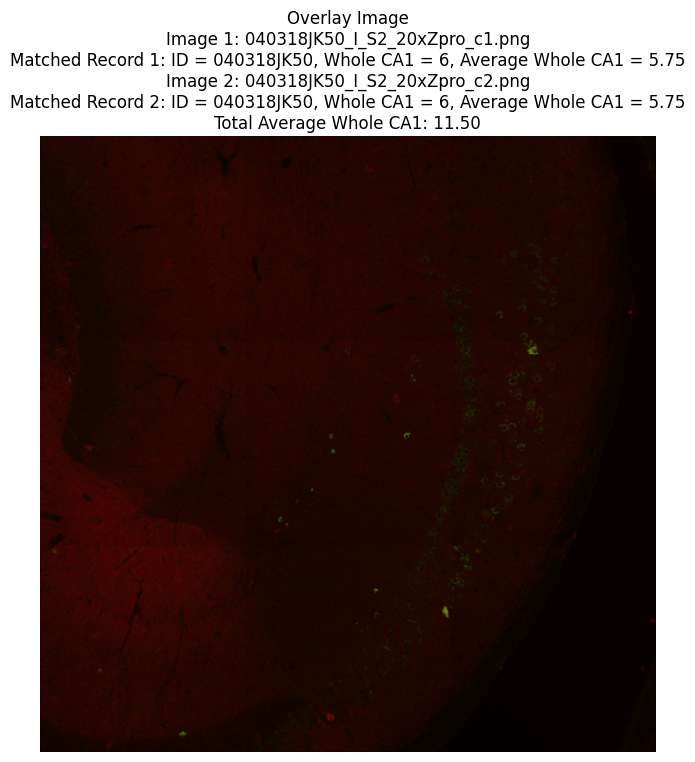

Processed pair 5/6
Current pair 6: 040318JK7_I_S1_20xZpro_c1.png with 040318JK7_I_S1_20xZpro_c2.png


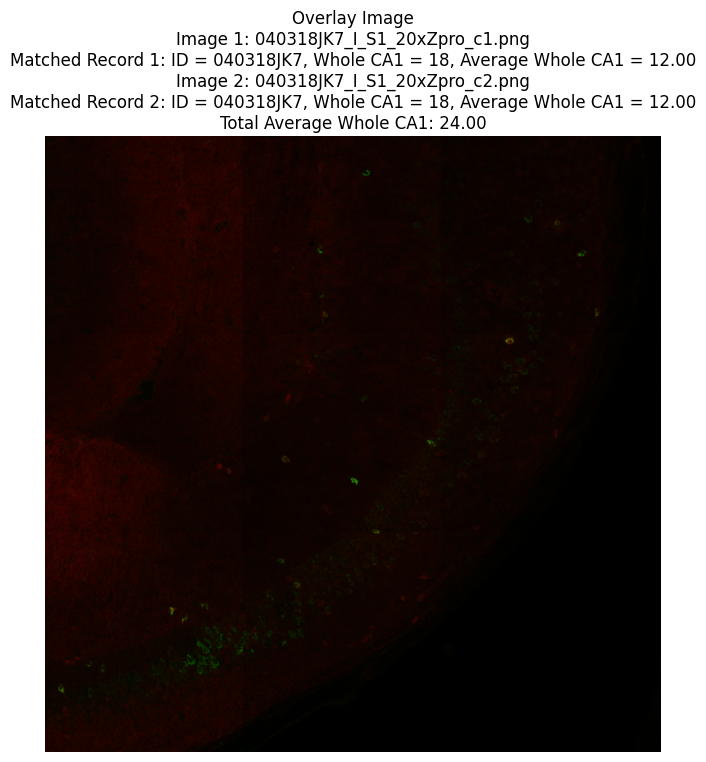

Processed pair 6/6
                                  Overlay Image Path  Total Average Whole CA1
0  C:\Users\David\Documents\Capstone\Final Projec...                     8.00
1  C:\Users\David\Documents\Capstone\Final Projec...                     8.00
2  C:\Users\David\Documents\Capstone\Final Projec...                    24.75
3  C:\Users\David\Documents\Capstone\Final Projec...                     7.50
4  C:\Users\David\Documents\Capstone\Final Projec...                    11.50
5  C:\Users\David\Documents\Capstone\Final Projec...                    24.00


In [30]:
def overlay_images(img1_path, img2_path, output_path, alpha=0.5):
    """Overlay two images with specified alpha for each."""
    img1 = Image.open(img1_path).convert("RGBA")
    img2 = Image.open(img2_path).convert("RGBA")

    # Resize images to match if they are not the same size
    if img1.size != img2.size:
        img1 = img1.resize(img2.size)
    img1_np = np.array(img1)
    img2_np = np.array(img2)

    # Overlay images
    overlay = cv2.addWeighted(img1_np, alpha, img2_np, 1 - alpha, 0)
    overlay_img = Image.fromarray(overlay)

    # Save the overlay image
    overlay_img.save(output_path)

    # Display the overlayed image
    return overlay_img

def display_overlayed_image(overlay_img, record1, record2):
    overlay = overlay_img  # Use the provided overlay image

    # Calculate the total Average Whole CA1 for the overlayed image
    total_average_ca1 = record1['Average Whole CA1'] + record2['Average Whole CA1']

    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
    plt.imshow(overlay)
    plt.title(f"Overlay Image\n"
              f"Image 1: {record1['Image name']}\n"
              f"Matched Record 1: ID = {record1['ID']}, Whole CA1 = {record1['Whole CA1']}, Average Whole CA1 = {record1['Average Whole CA1']:.2f}\n"
              f"Image 2: {record2['Image name']}\n"
              f"Matched Record 2: ID = {record2['ID']}, Whole CA1 = {record2['Whole CA1']}, Average Whole CA1 = {record2['Average Whole CA1']:.2f}\n"
              f"Total Average Whole CA1: {total_average_ca1:.2f}")
    plt.axis('off')  # Hide axes to focus only on the image
    plt.show()

def overlay_image_pairs(image_pairs, input_dir, output_dir, matched_df):
    # Initialize a list to collect data for the DataFrame
    overlay_data = []
    
    total_pairs = len(image_pairs)
    print("Overlaying image pairs...")
    print("Shape of matched_df:", matched_df.shape)
    print("Columns in matched_df:", matched_df.columns)
    print("Image names in dataset:", matched_df['Image name'].tolist())

    for i, (img1_name, img2_name) in enumerate(image_pairs.items(), start=1):
        print(f"Current pair {i}: {img1_name} with {img2_name}")
        
        if img1_name not in matched_df['Image name'].values or img2_name not in matched_df['Image name'].values:
            print(f"No match found for {img1_name} or {img2_name} in matched_df")
            continue

        # Retrieve records
        img1_record = matched_df[matched_df['Image name'] == img1_name].iloc[0]
        img2_record = matched_df[matched_df['Image name'] == img2_name].iloc[0]

        # Calculate the total Average Whole CA1
        total_average_whole_ca1 = img1_record['Average Whole CA1'] + img2_record['Average Whole CA1']

        img1_path = os.path.join(input_dir, img1_name)
        img2_path = os.path.join(input_dir, img2_name)
        output_path = os.path.join(output_dir, f"{img1_name[:-4]}_overlay.png")

        overlay_img = overlay_images(img1_path, img2_path, output_path, alpha=0.5)
        display_overlayed_image(overlay_img, img1_record, img2_record)
        
        # Append the data to the list
        overlay_data.append({
            'Overlay Image Path': output_path,
            'Total Average Whole CA1': total_average_whole_ca1
        })

        print(f"Processed pair {i}/{total_pairs}")

    # Create a DataFrame from the collected data
    overlay_df = pd.DataFrame(overlay_data)
    return overlay_df
       
# Define paths and data
overlay_image_dir = 'C:\\Users\\David\\Documents\\Capstone\\Final Project_Eplipesy\\MouseNeuroImages\\overlay_images'

# Overlay image pairs
os.makedirs(overlay_image_dir, exist_ok=True)
overlay_df = overlay_image_pairs(image_pairs, images_path, overlay_image_dir, matched_df)
print(overlay_df)

In [31]:
def filter_instances_by_color(image, red_threshold, green_threshold):
    """Apply color thresholds and return filtered image."""
    _, green_channel, red_channel = cv2.split(image)
    _, red_binary = cv2.threshold(red_channel, red_threshold, 255, cv2.THRESH_BINARY)
    _, green_binary = cv2.threshold(green_channel, green_threshold, 255, cv2.THRESH_BINARY)
    red_and_green = cv2.bitwise_and(red_binary, green_binary)
    filtered_image = cv2.bitwise_and(image, image, mask=red_and_green)
    return filtered_image

def filter_instances_by_size(image, min_area, max_area):
    """Apply size filtering to binary image and return filtered contours."""
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Use adaptive thresholding
    binary_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                         cv2.THRESH_BINARY, 11, 2)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours by size
    filtered_contours = [cnt for cnt in contours if min_area <= cv2.contourArea(cnt) <= max_area]
    
    return filtered_contours

def process_image_with_parameters(image_path, red_threshold, green_threshold):
    """Process an image with given red and green thresholds."""
    image = cv2.imread(image_path)
    if image is None:
        logging.warning(f"Image at {image_path} could not be loaded.")
        return None
    
    image = cv2.resize(image, (256, 256))
    filtered_image = filter_instances_by_color(image, red_threshold, green_threshold)
    return cv2.cvtColor(filtered_image, cv2.COLOR_BGR2GRAY).flatten()

def prepare_dataset(image_dir, overlay_df, red_threshold, green_threshold):
    print(overlay_df.columns)  # Debug: Check if 'Image name' is still a column
    X, y = [], []
    filenames = []
    for index, row in overlay_df.iterrows():
        image_path = os.path.join(image_dir, row['Overlay Image Path'])  # KeyError could occur here
        features = process_image_with_parameters(image_path, red_threshold, green_threshold)
        if features is not None:
            X.append(features)
            y.append(row['Total Average Whole CA1'])
            filenames.append(row['Overlay Image Path'])
    return np.array(X), np.array(y), filenames
    
def perform_regression(image_dir, overlay_df, param_grid):
    """Perform regression analysis with grid search."""
    best_model = None
    best_score = float('inf')
    best_params = None

    for params in ParameterGrid(param_grid):
        logging.info(f"Testing parameters: {params}")
        X, y, _ = prepare_dataset(image_dir, overlay_df, params['red_threshold'], params['green_threshold'])

        if len(X) == 0:
            logging.warning("No data to fit the model.")
            continue

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        model = RandomForestRegressor(n_estimators=params['n_estimators'], max_depth=params['max_depth'], random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)

        if mae < best_score:
            best_score = mae
            best_params = params
            best_model = model
            logging.info(f"New best model with parameters: {best_params} and score: {best_score}")

    logging.info(f"Best Parameters: {best_params}")
    logging.info(f"Best Score: {best_score}")

    return best_model, best_params

param_grid = {
    'red_threshold': [55, 60],
    'green_threshold': [50, 55, 60],
    'n_estimators': [50],
    'max_depth': [None]
}

best_model, best_params = perform_regression(overlay_image_dir, overlay_df, param_grid)


Index(['Overlay Image Path', 'Total Average Whole CA1'], dtype='object')
Index(['Overlay Image Path', 'Total Average Whole CA1'], dtype='object')
Index(['Overlay Image Path', 'Total Average Whole CA1'], dtype='object')
Index(['Overlay Image Path', 'Total Average Whole CA1'], dtype='object')
Index(['Overlay Image Path', 'Total Average Whole CA1'], dtype='object')
Index(['Overlay Image Path', 'Total Average Whole CA1'], dtype='object')


                       Overlay Image Path  Total Average Whole CA1  \
0   022218JK0_C_S2_20xZpro_c1_overlay.png                     8.00   
1   022218JK0_I_S1_20xZpro_c1_overlay.png                     8.00   
2  031218JK10_I_S3_20xZpro_c1_overlay.png                    24.75   
3  040318JK12_I_S2_20xZpro_c1_overlay.png                     7.50   
4  040318JK50_I_S2_20xZpro_c1_overlay.png                    11.50   
5   040318JK7_I_S1_20xZpro_c1_overlay.png                    24.00   

   Predicted Total Average Whole CA1  
0                             12.870  
1                             12.870  
2                             20.190  
3                             12.870  
4                             11.755  
5                             19.410  


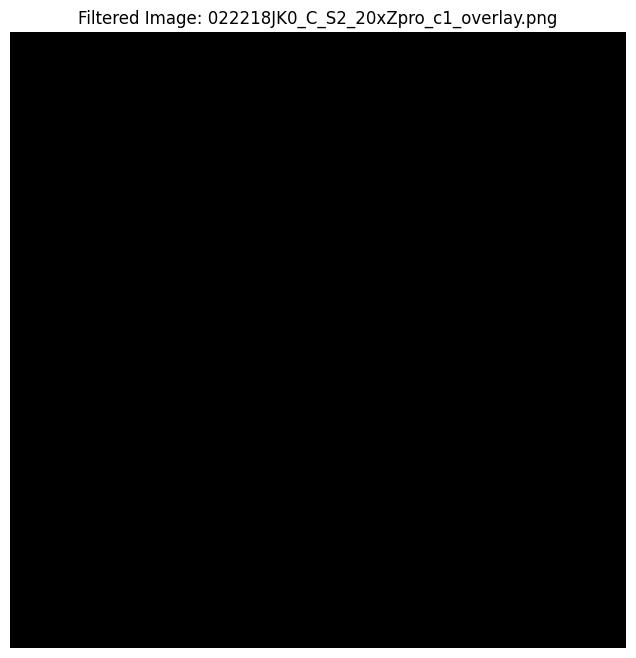

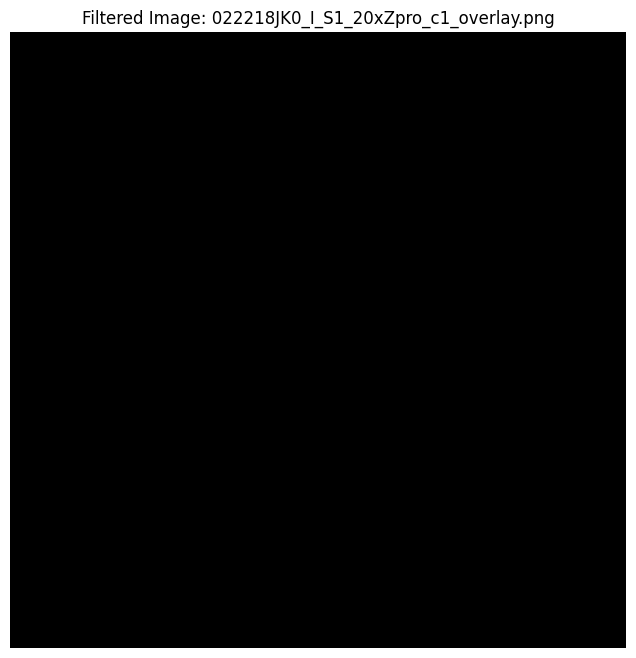

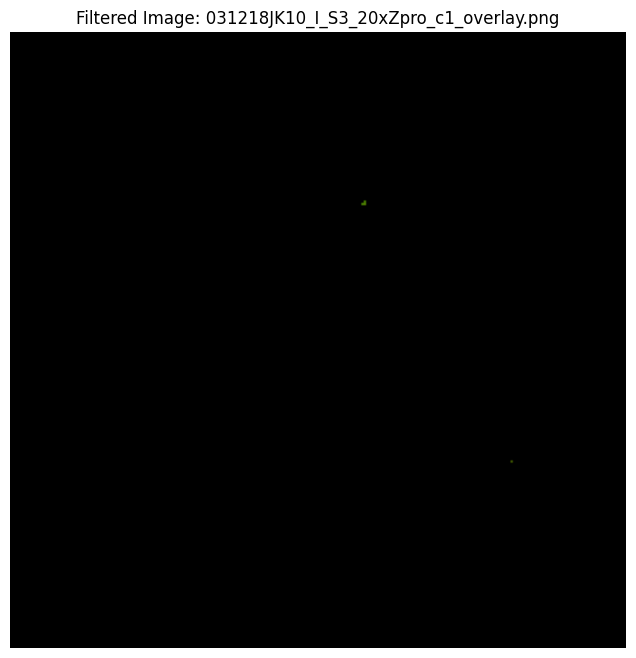

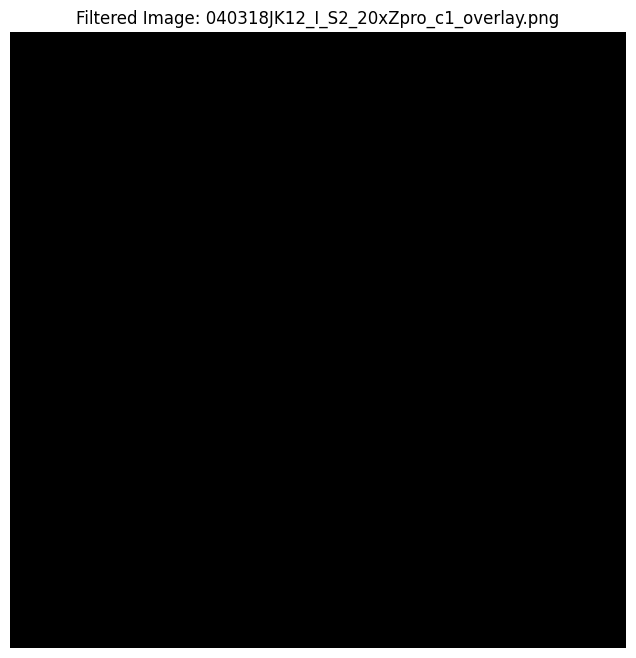

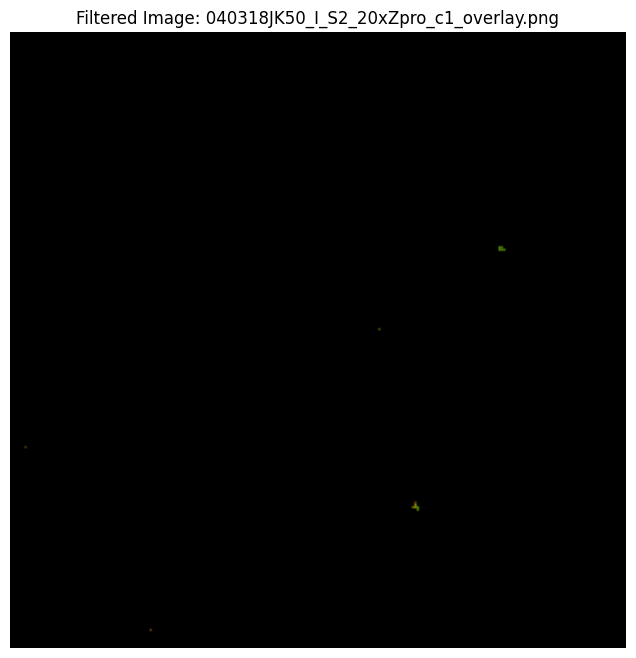

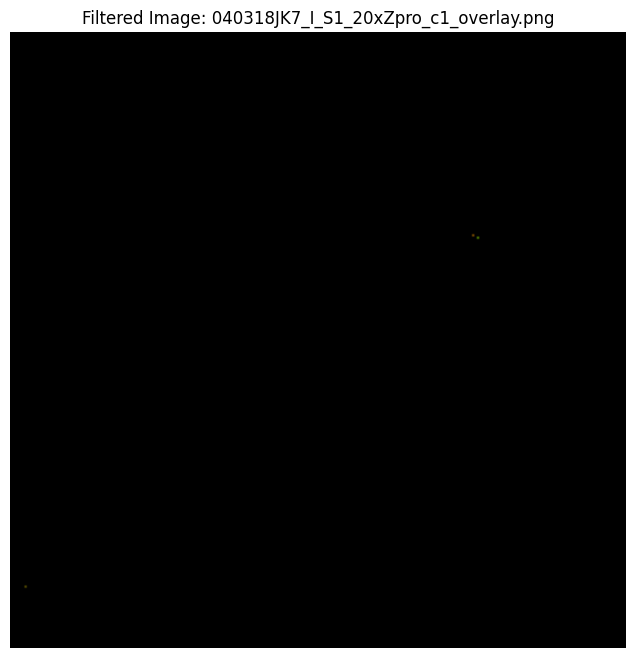

In [32]:
def predict_all_images(image_dir, overlay_df, best_model, red_threshold, green_threshold):
    # Create a new column for the predicted values initialized with NaNs
    overlay_df['Predicted Total Average Whole CA1'] = np.nan
    
    for index, row in overlay_df.iterrows():
        image_path = os.path.join(image_dir, row['Overlay Image Path'])
        features = process_image_with_parameters(image_path, red_threshold, green_threshold)
        if features is not None:
            # Predict the number of instances for the current image
            predicted_instances = best_model.predict([features])[0]
            # Add the prediction to the new column in the dataframe
            overlay_df.at[index, 'Predicted Total Average Whole CA1'] = predicted_instances
            logging.info(f"Image: {row['Overlay Image Path']}, Predicted Total Average Whole CA1: {predicted_instances}")

    return overlay_df

# Assuming perform_regression has already been run and best_model, best_params are available
overlay_df_with_predictions = predict_all_images(
    overlay_image_dir,
    overlay_df,
    best_model,
    best_params['red_threshold'],
    best_params['green_threshold']
)

# Now, overlay_df_with_predictions contains the original data along with a new column for predictions
# Extracting just the image name from the full path in the 'Overlay Image Path' column
overlay_df_with_predictions['Overlay Image Path'] = overlay_df_with_predictions['Overlay Image Path'].apply(lambda x: os.path.basename(x))

print(overlay_df_with_predictions)

def visualize_filtered_images(image_dir, overlay_df, red_threshold, green_threshold):
    for index, row in overlay_df.iterrows():
        image_path = os.path.join(image_dir, row['Overlay Image Path'])
        image = cv2.imread(image_path)
        if image is None:
            logging.warning(f"Image at {image_path} could not be loaded.")
            continue
        
        # Resize the image for visualization if needed
        image = cv2.resize(image, (256, 256))
        
        # Apply color filtering
        filtered_image = filter_instances_by_color(image, red_threshold, green_threshold)
        
        # Display the filtered image
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Filtered Image: {row['Overlay Image Path']}")
        plt.axis('off')
        plt.show()

# Assuming overlay_df and overlay_image_dir are defined
visualize_filtered_images(overlay_image_dir, overlay_df, best_params['red_threshold'], best_params['green_threshold'])

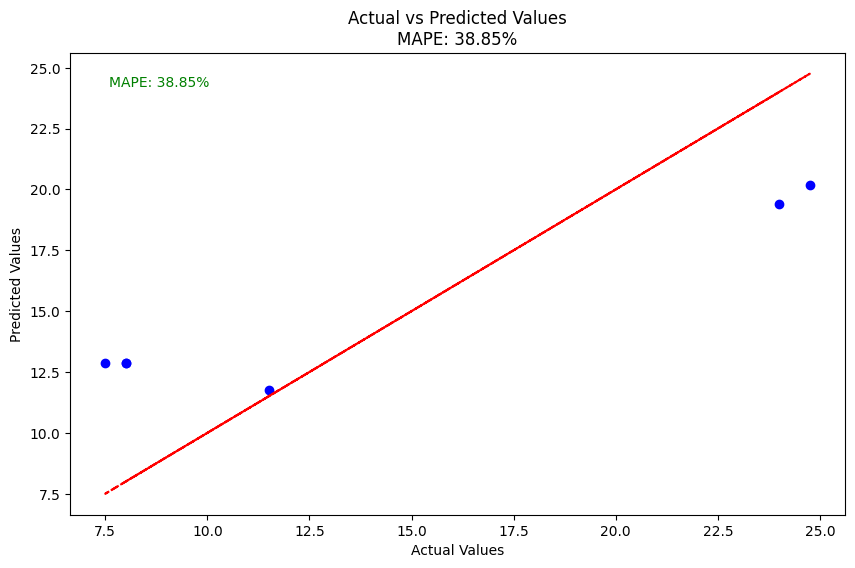

In [33]:
def visualize_predictions(actual_values, predicted_values):
    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    
    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_values, predicted_values, color='blue')
    plt.plot(actual_values, actual_values, color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values\nMAPE: {mape:.2f}%')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    
    # Annotate the MAPE value on the plot
    plt.text(0.05, 0.95, f'MAPE: {mape:.2f}%', transform=plt.gca().transAxes, va='top', ha='left', color='green')
    
    plt.show()


# Extract actual and predicted values from overlay_df_with_predictions
actual_values = overlay_df_with_predictions['Total Average Whole CA1']
predicted_values = overlay_df_with_predictions['Predicted Total Average Whole CA1']

# Visualize the predictions
visualize_predictions(actual_values, predicted_values)

In [36]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import Image

# Base directory where the original and augmented images are stored
base_dir = 'C:\\Users\\David\\Documents\\Capstone\\Final Project_Eplipesy\\MouseNeuroImages'
original_overlay_image_dir = os.path.join(base_dir, 'overlay_images')
augmented_overlay_image_dir = os.path.join(base_dir, 'augmented_overlay_images')

# Ensure the directories exist
os.makedirs(original_overlay_image_dir, exist_ok=True)
os.makedirs(augmented_overlay_image_dir, exist_ok=True)

# Dataframe to hold augmented image paths and their counts
augmented_overlay_df = pd.DataFrame(columns=['Augmented Image Path', 'Total Average Whole CA1'])

# Instantiate the ImageDataGenerator with the desired augmentations
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8,1.2]
)

# Process each image and its count from the original directory
for index, row in overlay_df.iterrows():
    filename = os.path.basename(row['Overlay Image Path'])
    file_extension = os.path.splitext(filename)[1]
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        original_image_path = os.path.join(original_overlay_image_dir, filename)
        # Copy original image to augmented directory
        shutil.copy2(original_image_path, augmented_overlay_image_dir)
        
        # Add original image information to dataframe
        original_image_augmented_path = os.path.join(augmented_overlay_image_dir, filename)
        augmented_overlay_df = pd.concat([augmented_overlay_df, pd.DataFrame({
            'Augmented Image Path': [original_image_augmented_path],
            'Total Average Whole CA1': [row['Total Average Whole CA1']]
        })], ignore_index=True)
        
        # Augment and save the image
        image = load_img(original_image_path)
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        for x, val in zip(datagen.flow(image, batch_size=1), range(1)):  # Ensure only one iteration
            img = Image.fromarray((x[0] * 255).astype(np.uint8))  # Rescale back to 0-255 and convert to uint8
            augmented_filename = filename[:-len(file_extension)] + "_aug" + file_extension
            augmented_image_path = os.path.join(augmented_overlay_image_dir, augmented_filename)
            img.save(augmented_image_path)  # Save the image manually
            break  # Stop after generating one augmented image
        
        # Add augmented image information to dataframe
        new_row = pd.DataFrame({
            'Augmented Image Path': [augmented_image_path],
            'Total Average Whole CA1': [row['Total Average Whole CA1']]
        })
        augmented_overlay_df = pd.concat([augmented_overlay_df, new_row], ignore_index=True)

# Save the augmented dataframe as a CSV file
augmented_overlay_df.to_csv(os.path.join(augmented_overlay_image_dir, 'augmented_overlay_df.csv'), index=False)


C:\Users\David\AppData\Local\Temp\ipykernel_11412\3815498193.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  augmented_overlay_df = pd.concat([augmented_overlay_df, pd.DataFrame({


In [35]:
# Load your augmented images dataframe
augmented_overlay_df = pd.read_csv(os.path.join(base_dir, 'augmented_overlay_images', 'augmented_overlay_df.csv'))

# Split the data into train, validation, and test sets
train_df, test_val_df = train_test_split(augmented_overlay_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

# Save these dataframes
train_df.to_csv(os.path.join(base_dir, 'augmented_overlay_images', 'train_df.csv'), index=False)
val_df.to_csv(os.path.join(base_dir, 'augmented_overlay_images', 'val_df.csv'), index=False)
test_df.to_csv(os.path.join(base_dir, 'augmented_overlay_images', 'test_df.csv'), index=False)

# Directories for the train, validation, and test sets
train_dir = os.path.join(augmented_overlay_image_dir, 'train')
val_dir = os.path.join(augmented_overlay_image_dir, 'validation')
test_dir = os.path.join(augmented_overlay_image_dir, 'test')

# Create the directories if they do not exist
for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)

# Function to copy images to specific directories based on their DataFrame
def copy_images_to_directory(df, destination_dir):
    for index, row in df.iterrows():
        source_path = row['Augmented Image Path']
        filename = os.path.basename(source_path)
        destination_path = os.path.join(destination_dir, filename)
        shutil.copy2(source_path, destination_path)

# Copy images according to their sets
copy_images_to_directory(train_df, train_dir)
copy_images_to_directory(val_df, val_dir)
copy_images_to_directory(test_df, test_dir)

# Function to find the first image in the directory and return its dimensions
def get_image_dimensions(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                if image is not None:
                    return image.shape[0], image.shape[1]  # height, width
    return None, None  # In case there are no images in the directory

# Get the height and width of the first image found in the train directory
image_height, image_width = get_image_dimensions(train_dir)
print(f"The first image's dimensions are {image_height}x{image_width}")


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\David\\Documents\\Capstone\\Final Project_Eplipesy\\MouseNeuroImages\\augmented_overlay_images\\augmented_overlay_df.csv'

Checking for the type of GPU available on the machine:

Tensorflow run with GPU support requires a compatible GPU, such as CUDA-compatible NVIDIA GPU

Windows: wmic path win32_VideoController get name

Linux: lspci | grep -i nvidia

If no CUDA-compatible GPU is available, the Intel Math Kernel Library for Deep Neural Networks can optimize performance on Intel CPUs

pip install intel-tensorflow --user


In [23]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU found!")

No GPU found!


In [26]:
def load_images_and_masks(image_dir, mask_dir, image_size=(256, 256)):
    images = []
    masks = []

    for filename in os.listdir(image_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename)  # Assumes mask has same filename

            img = load_img(img_path, target_size=image_size)
            img = img_to_array(img) / 255.0
            images.append(img)
            
            mask = load_img(mask_path, target_size=image_size, color_mode='grayscale')
            mask = img_to_array(mask) / 255.0  # Assuming mask is grayscale and has a single channel
            masks.append(mask)

    return np.array(images), np.array(masks)

# Example usage
all_images, all_masks = load_images_and_masks(image_dir, mask_dir)


NameError: name 'mask_dir' is not defined

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    # Contracting Path
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    # Expansive Path
    u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1], axis=3)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)  # Use 'sigmoid' for binary segmentation, 'softmax' for multi-class

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 256, 256, 16)      │             448 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256, 256, 16)      │               0 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 256, 256, 16)      │           2,320 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 128, 128, 16)      │               0 │ conv2d_4[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 128, 128, 32)      │           4,640 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128, 128, 32)      │               0 │ conv2d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 128, 128, 32)      │           9,248 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 64, 64, 32)        │               0 │ conv2d_6[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 64, 64, 64)        │               0 │ conv2d_7[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 64, 64, 64)        │          36,928 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose              │ (None, 128, 128, 32)      │           8,224 │ conv2d_8[0][0]             │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 128, 128, 64)      │               0 │ conv2d_transpose[0][0],    │
│                               │                           │                 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 128, 128, 32)      │          18,464 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 117,041 (457.19 KB)

 Trainable params: 117,041 (457.19 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with images and their corresponding masks
model.fit(all_images, all_masks, batch_size=16, epochs=10, validation_split=0.1)